In [1]:
from optionCombo import optionModel,preInit

In [2]:
global currency
global url
currency = 'BTC'
#url = 'https://www.deribit.com/api/v2/public/'
#option_data,expirList = collect_clean_data()

# COLLECT DELTA EXCHANGE OPTION DATA

In [5]:
import requests
import pandas as pd
from datetime import datetime
import numpy as np
headers = {
  'Accept': 'application/json'
}

r = requests.get('https://api.delta.exchange/v2/tickers', params={'contract_types':'call_options'

}, headers = headers)
r = r.json()['result']
r2 = requests.get('https://api.delta.exchange/v2/tickers', params={'contract_types':'put_options'

}, headers = headers)
r2 = r2.json()['result']
r.extend(r2)
data = r
option_data = pd.DataFrame(data)
option_data['infos'] = option_data['symbol'].apply(lambda x:x.split('-'))
option_data['expiration'] = option_data['infos'].apply(lambda x:pd.to_datetime(x[3]))#pd.to_datetime(option_data['expiration'])#
option_data['is_call'] = option_data['infos'].apply(lambda x:x[0])
option_data['K'] = option_data['infos'].apply(lambda x:x[2])
option_data['ticker'] = option_data['infos'].apply(lambda x:x[1])
option_data['askIv'] = option_data['quotes'].apply(lambda x:x['ask_iv'])
option_data['bidIv'] = option_data['quotes'].apply(lambda x:x['bid_iv'])
option_data[['K','bidIV','askIV']] = option_data[['K','bidIv','askIv']].astype('float')
option_data['expiry'] = option_data['expiration'].apply(lambda x: (pd.to_datetime(x) - datetime.now()) / (pd.to_timedelta('365d')))
option_data = option_data.loc[option_data.ticker==currency][['is_call','K','askIV','bidIV','expiry','expiration']]
expirList = option_data.sort_values(by=['expiration'])['expiration'].unique()


In [6]:
expirList

<DatetimeArray>
['2023-04-08 00:00:00', '2023-07-18 00:00:00', '2023-07-19 00:00:00',
 '2023-07-20 00:00:00', '2023-07-21 00:00:00', '2023-07-28 00:00:00',
 '2023-08-25 00:00:00', '2023-09-29 00:00:00']
Length: 8, dtype: datetime64[ns]

In [7]:
'''
choose a expiry date, doesn't support mutiple expiry dates at the moment
'''
expirDate = '2023-07-21 00:00:00'

In [8]:
'''
The option DataFrame should have the following structure:
'''
option_data

,is_call,K,askIV,bidIV,expiry,expiration
0,C,32000.0,0.401896,0.398082,0.025619,2023-07-28
1,C,31000.0,0.391828,0.379572,0.025619,2023-07-28
2,C,30000.0,0.381520,0.369013,0.025619,2023-07-28
3,C,29000.0,0.401458,0.377392,0.025619,2023-07-28
4,C,28000.0,0.459081,0.413199,0.025619,2023-07-28
...,...,...,...,...,...,...
693,P,28900.0,0.747635,0.548081,-0.001778,2023-07-18
694,P,28800.0,0.808781,0.595498,-0.001778,2023-07-18
695,P,28600.0,0.455701,0.427475,0.000962,2023-07-19
696,P,28200.0,0.461457,0.438897,0.003701,2023-07-20


# COLLECT OHLCV DATA To Calculate EXPECTED PRICE RANGE

In [9]:
import ccxt
def fetchprice(symbol,exchange = 'binance'):
    res = {}
    exchange = getattr(ccxt, exchange)()


    while True:
        try:
            data = exchange.fetch_ohlcv(symbol, '15m', None, 1000)
            header = ["Timestamp", "open", "high", "low", "close", "volume"]
            df = pd.DataFrame(data, columns=header)
            df = df[["Timestamp", "open", "high", "low", "close", "volume"]]
            break
        except Exception as e:
            print(e)
            time.sleep(1)
    for i in range(20):
        while True:
            try:
                since = df.Timestamp.values[0] - 1000*15*60*1000
                data = exchange.fetch_ohlcv(symbol, '15m', since, 1000)
                header = ["Timestamp", "open", "high", "low", "close", "volume"]
                df1 = pd.DataFrame(data, columns=header)
                df1 = df1[["Timestamp", "open", "high", "low", "close", "volume"]]
                df = pd.concat([df1,df]).reset_index(drop=True)
                break
            except Exception as e:
                print(e)
                time.sleep(1)
    df = df[["Timestamp", "open", "high", "low", "close", "volume"]]
    df['Timestamp'] = pd.to_datetime(df['Timestamp'] / 1000, unit="s")
    df["open"] = pd.to_numeric(df["open"])
    df["high"] = pd.to_numeric(df["high"])
    df["low"] = pd.to_numeric(df["low"])
    df["close"] = pd.to_numeric(df["close"])
    df["volume"] = pd.to_numeric(df["volume"])
    return df

In [10]:
pricedata = fetchprice('BTCUSDT')

In [11]:
'''
The price DataFrame should have the following structure:
'''
pricedata

,Timestamp,open,high,low,close,volume
0,2022-12-11 13:45:00,17150.86,17159.61,17127.96,17157.50,3127.95880
1,2022-12-11 14:00:00,17157.21,17159.58,17136.40,17146.80,2578.42902
2,2022-12-11 14:15:00,17146.59,17154.68,17130.10,17140.17,1869.07015
3,2022-12-11 14:30:00,17140.53,17149.51,17137.53,17149.17,1236.86272
4,2022-12-11 14:45:00,17149.36,17159.23,17149.09,17154.75,1222.47182
...,...,...,...,...,...,...
20995,2023-07-18 06:30:00,30047.11,30047.12,29930.55,29966.48,566.45515
20996,2023-07-18 06:45:00,29966.49,30015.32,29921.54,29988.62,350.93441
20997,2023-07-18 07:00:00,29988.61,30036.00,29969.06,30028.01,327.24541
20998,2023-07-18 07:15:00,30028.01,30040.39,30016.34,30020.57,216.13641


In [12]:
spotPrice =  pricedata.close.values[-1]

In [13]:
"""
built in function to calculate expeted range
"""
bound = preInit.calRange(pricedata,expirDate,interval_width=2.5)

In [14]:
bound

(27527.93434259958, 33031.6268587661)

In [15]:
preInit.calRange(pricedata,expirDate,interval_width=1)

(29075.0558808683, 31273.969596057632)

In [16]:
'''

This section of the code is responsible for the pre-computation step. It prepares and computes the 
necessary data for further calculations related to the option combinations.

In this step, you need to select the expiry date for your option strategy and provide the required 
option data and price bound.

'''

preOption,joined1,price = preInit.Prep( expirDate, optionDf = option_data,spotPrice = spotPrice,Bound = (29076.152716934437, 33036.31844391873), BoundExtend=1.2, strikePriceRange=0.3)

In [18]:
'''
This section of the code is responsible for iterating through all possible option combinations. In 
the "optiontypes" parameter, a two-dimensional list should be provided, where each element represents 
a call option (1) or a put option (-1). For example, [[1,1,1],[-1,-1,1,1]] indicates that there are 
three call options followed by two put options and two call options.

The "tradetypes" parameter determines whether to sell or buy the corresponding options. For instance, 
if "optiontypes" is [[1,1,1]], the "tradetypes" should be [[1,-1,1]] or [[[1,-1,1],[1,1,1]]]. 
By default, "tradetypes" is set to None, which includes all possible combinations.

The "maxquantity" parameter represents the maximum quantity allowed for a single option trade amount.
'''

model = optionModel.option_model(price, joined1,preOption,optiontypes = [[-1,-1,-1]],tradetypes=None, maxquantity=4)  # Init
df = model.options_model_finder()                                                                           # start looping

100%|███████████████████████████████████████████████████████████████████████████| 39600/39600 [00:40<00:00, 984.85it/s]


In [19]:
'''

The output of the code snippet contains all the possible combinations based on the provided 
parameters. You have the flexibility to filter the results according to your specific requirements.

'''
df['v/t'] = abs(df['mean_vega']/abs(df['mean_theta']))
df['bb'] = df['probal']*df['RR']/df['maxRisk']/df['mean_delta']
temp = df.sort_values(by=['bb','mean_delta','maxRisk','RR','v/t','mean_vega','mean_theta'], ascending=[False,True,True,False,True,False,False])
temp

,para,stra,maxRisk,probal,RR,wv,wp,bv,bp,wd,bd,mean_delta,std_delta,mean_vega,mean_theta,std_theta,premium,minReward,v/t,bb
12744,"[30025.02, [0.0064411813195395734, 0.006441181...",P_27500_3__P_31000_4__P_34500_-4,0.023696,0.500000,24.134226,0.85,29076.1527,1.15,33036.3184,0.0,2.351031,0.004075,2.218697,13.429013,-172.836175,252.758339,22088.3582,-324.0710,0.077698,124953.383952
18555,"[30025.02, [0.0064411813195395734, 0.006441181...",P_30500_4__P_32500_-2__P_34500_-1,0.152982,0.633333,5.147676,0.85,30441.7271,1.15,33036.3184,0.0,2.351031,0.000187,1.082589,8.872229,-123.897384,227.887037,11936.2577,-1053.7390,0.071609,114112.747597
1218,"[30025.02, [0.0064411813195395734, 0.006441181...",P_28000_1__P_30500_2__P_33000_-2,0.072364,0.600000,13.819052,0.85,29076.1527,1.15,33036.3184,0.0,2.351031,0.003628,0.860721,4.360803,-63.574727,140.896679,7220.3199,-337.4035,0.068593,31577.951084
1226,"[30025.02, [0.0064411813195395734, 0.006441181...",P_27500_1__P_30000_2__P_32500_-2,0.159335,0.666667,6.276103,0.85,29076.1527,1.15,32490.0887,0.0,2.351031,0.000936,0.810808,2.549413,-43.626115,140.028350,5570.3550,-687.1810,0.058438,28063.300863
433,"[30025.02, [0.0064411813195395734, 0.006441181...",P_26500_1__P_30000_1__P_33500_-1,0.107866,0.666667,7.910114,0.85,29076.1527,1.15,33036.3184,0.0,2.351031,0.001957,0.593790,2.043448,-29.136093,63.460040,3782.1015,-340.7721,0.070135,24978.611518
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17181,"[30025.02, [0.0064411812878297815, 0.006441181...",P_26000_4__P_30000_3__P_34000_-3,0.093011,0.666667,7.920242,0.85,29485.8250,1.15,33036.3184,0.0,2.351031,-0.007169,2.066173,7.142947,-97.075676,177.760878,12844.7574,-1021.1556,0.073581,-7918.754909
1204,"[30025.02, [0.0064411813195395734, 0.006441181...",P_28500_1__P_31000_2__P_33500_-2,0.037103,0.500000,21.767755,0.85,29076.1527,1.15,33036.3184,0.0,2.351031,-0.024930,0.873664,6.029211,-81.607871,138.206720,9061.5362,-178.8774,0.073880,-11766.740710
2002,"[30025.02, [0.0064411813195395734, 0.006441181...",P_29500_1__P_31500_3__P_33500_-3,0.046631,0.433333,16.241347,0.85,30851.3994,1.15,33036.3184,0.0,2.351031,-0.011998,1.079644,9.570370,-129.200570,199.895447,15091.3081,-267.3199,0.074074,-12579.011079
7435,"[30025.02, [0.0064411813195395734, 0.006441181...",P_27500_2__P_30500_3__P_33500_-3,0.058425,0.600000,14.316025,0.85,29485.8250,1.15,33036.3184,0.0,2.351031,-0.008059,1.508412,7.592199,-105.214229,200.179044,12320.7852,-496.7970,0.072159,-18243.756691


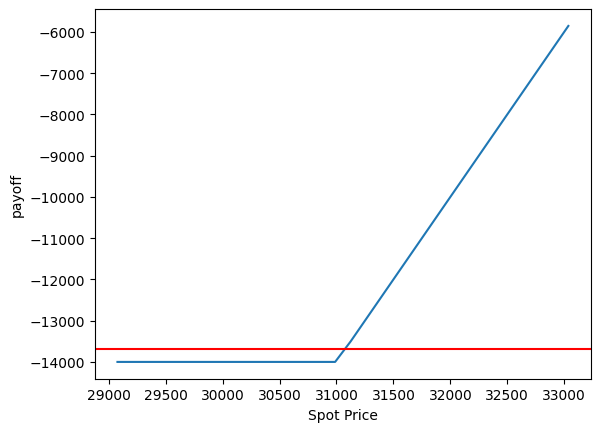

net premium -13675.929
premium 22088.3582
Risk Reward 24.13422552465342
probal 0.5
lowest possible premium -14000.000000000002
max risk 0.023696452358008126
worst case, vol: 0.85 price: 29076.1527 daysTillExpir: 0.0
best case, vol: 1.15 price: 33036.3184 daysTillExpir: 2.3510311816319445
mean delta0.004075416666666671
min theta -1306.3043
min vega -12.132000000000001
P_27500_3__P_31000_4__P_34500_-4


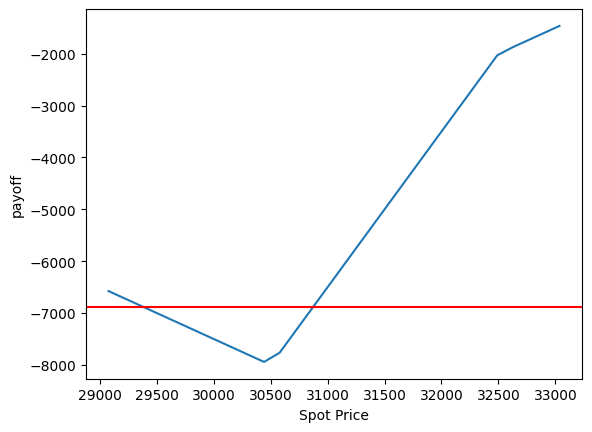

net premium -6887.9881000000005
premium 11936.2577
Risk Reward 5.147675562924029
probal 0.6333333333333333
lowest possible premium -7941.7271
max risk 0.15298211679546883
worst case, vol: 0.85 price: 30441.7271 daysTillExpir: 0.0
best case, vol: 1.15 price: 33036.3184 daysTillExpir: 2.3510311816319445
mean delta0.0001867534722222206
min theta -1024.119
min vega -20.7989
P_30500_4__P_32500_-2__P_34500_-1


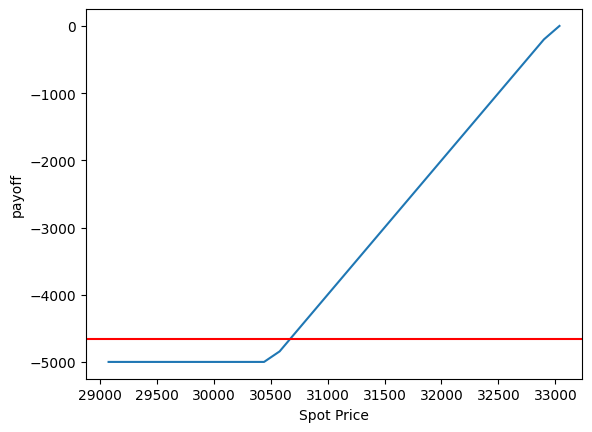

net premium -4662.5965
premium 7220.3199
Risk Reward 13.819051965969514
probal 0.6
lowest possible premium -5000.0
max risk 0.0723638642117113
worst case, vol: 0.85 price: 29076.1527 daysTillExpir: 0.0
best case, vol: 1.15 price: 33036.3184 daysTillExpir: 2.3510311816319445
mean delta0.0036284722222222196
min theta -656.0469
min vega -21.0596
P_28000_1__P_30500_2__P_33000_-2


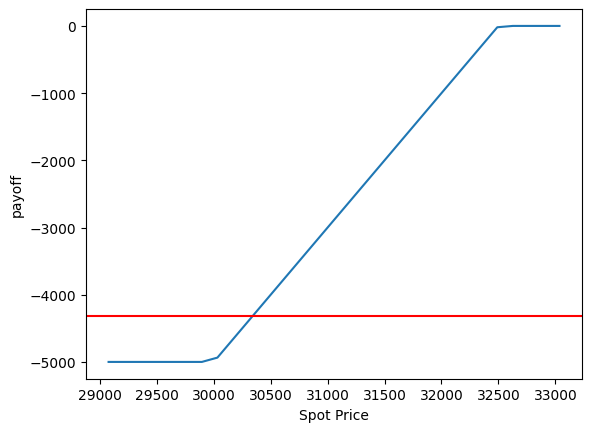

net premium -4312.819
premium 5570.3550000000005
Risk Reward 6.276103384697777
probal 0.6666666666666666
lowest possible premium -5000.0
max risk 0.1593345327035518
worst case, vol: 0.85 price: 29076.1527 daysTillExpir: 0.0
best case, vol: 1.15 price: 32490.0887 daysTillExpir: 2.3510311816319445
mean delta0.0009357291666666644
min theta -642.4898
min vega -20.7546
P_27500_1__P_30000_2__P_32500_-2


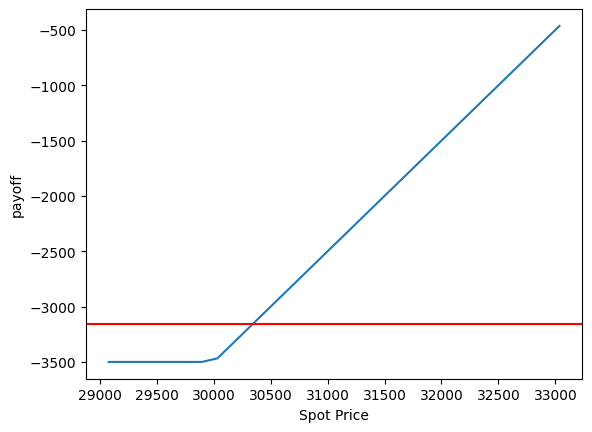

net premium -3159.2279
premium 3782.1014999999998
Risk Reward 7.910114413709325
probal 0.6666666666666666
lowest possible premium -3500.0000000000005
max risk 0.10786562754779438
worst case, vol: 0.85 price: 29076.1527 daysTillExpir: 0.0
best case, vol: 1.15 price: 33036.3184 daysTillExpir: 2.3510311816319445
mean delta0.0019572222222222217
min theta -337.6633
min vega -9.6052
P_26500_1__P_30000_1__P_33500_-1


In [20]:
'''
The plotted graph consists of two lines: a blue line representing the payoff curve and a red line 
representing the net premium.

The blue line represents the payoff curve, which depicts the potential profit or loss at expiration 
for the option combination. It shows how the payoff varies with different underlying asset prices. 
The shape of the curve provides insights into the risk and potential returns of the option combination.

The red line represents the net premium, which is the total premium paid or received for the option 
combination. It indicates the initial cost or income associated with entering the option positions.

By visualizing the payoff curve and net premium, you can gain a better understanding of the potential 
outcomes and financial implications of the option combination under different market scenarios. 
This can assist in evaluating the risk-reward profile and making informed decisions regarding option 
trading strategies.
'''
for para in temp.para[:5]:
    model.model_plot(para)

In [ ]:
price